# Imports, Definitions & Functions

In [ ]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
import os
import sys


from scipy.signal import find_peaks
from scipy.signal import savgol_filter

In [ ]:

def time2timestamp(days): 
  ''' 
  takes in a numpy array of representing calendar days of when each sample were collected. 
  return a numpy array of timestamp (integers) to be used an ordinal feature
  ''' 
  counter = 0 
  timestamp = np.zeros_like(days, dtype = int) 
  for i in range(1, len(timestamp)) : 
    if days[i] != days[i-1]: 
      counter += 1 
    timestamp[i] = counter
  return timestamp 


In [ ]:
%%capture 

def download_data():
  # download the data file 
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies \
    --no-check-certificate 'https://docs.google.com/uc?export=download&id=1u78Z2-WhhyHzoHf6OtBnxWETnjBw7pg8' \
    -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1u78Z2-WhhyHzoHf6OtBnxWETnjBw7pg8" -O corona_tested_individuals_ver_0083.english.csv && rm -rf /tmp/cookies.txt
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies \
    --no-check-certificate 'https://docs.google.com/uc?export=download&id=1u8R1viz0ty6zR2CuVghRPQrv5XwDNOpk' \
    -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1u8R1viz0ty6zR2CuVghRPQrv5XwDNOpk" -O corona_tested_individuals_ver_006.english.csv && rm -rf /tmp/cookies.txt


# download the data file
download_data()

# Prepare

In [ ]:
df_small = pd.read_csv('corona_tested_individuals_ver_006.english.csv')
df = pd.read_csv('corona_tested_individuals_ver_0083.english.csv')

df = df.assign(contact_with_confirmed = lambda x : x.test_indication == 'Contact with confirmed')
# may also drop 'gender', 'age_60_and_above' because they have missing values, 
# but will keep them for now since they will be part of the anlaysis
df = df.drop(columns = ['test_indication'], axis = 0) 

df['test_date'] = pd.to_datetime(df.test_date, infer_datetime_format = True) 
df['month'] = df.test_date.dt.month 
df['day'] = df.test_date.dt.day
df.drop(columns = ['test_date'], inplace = True) 

results = df.corona_result.values
age_above_60 = df.age_60_and_above.values 
gender = df.gender.values 

binary_age = [1 if age_above_60[i] == 'Yes' else 0 for i in range(len(df)) ]
binary_results = [1 if results[i] == 'positive' else 0 for i in range(len(df)) ]
binary_gender = [1 if gender[i] == 'male' else 0 for i in range(len(df)) ]
df['corona_result'] = np.array(binary_results, dtype = np.int32)  
df['age_60_and_above'] = np.array(binary_age, dtype = np.int32)
df['gender'] = np.array(binary_gender, dtype = np.int32) 

month_groubed = df.groupby('month').sum().astype(dtype = np.int32)
day_groubed = df.groupby('day').sum().astype(dtype = np.int32)
symptom_cols = ['cough', 'fever', 'cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'corona_result']
time_cols = ['test_date', 'month', 'day'] 
variant_cols = [col+'_monthly' for col in symptom_cols] + [col+'_daily' for col in symptom_cols] 


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,contact_with_confirmed,month,day
0,0,0,0,0,0,0,0,1,0,11,12
1,0,1,0,0,0,0,0,1,0,11,12
2,0,0,0,0,0,0,1,0,0,11,12
3,0,0,0,0,0,0,0,1,0,11,12
4,0,1,0,0,0,0,0,1,1,11,12


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742596 entries, 0 to 2742595
Data columns (total 11 columns):
 #   Column                  Dtype
---  ------                  -----
 0   cough                   int32
 1   fever                   int32
 2   sore_throat             int32
 3   shortness_of_breath     int32
 4   head_ache               int32
 5   corona_result           int32
 6   age_60_and_above        int32
 7   gender                  int32
 8   contact_with_confirmed  int32
 9   month                   int32
 10  day                     int32
dtypes: int32(11)
memory usage: 115.1 MB


In [ ]:
month_groubed.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 3 to 11
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   cough                   9 non-null      int32
 1   fever                   9 non-null      int32
 2   sore_throat             9 non-null      int32
 3   shortness_of_breath     9 non-null      int32
 4   head_ache               9 non-null      int32
 5   corona_result           9 non-null      int32
 6   age_60_and_above        9 non-null      int32
 7   gender                  9 non-null      int32
 8   contact_with_confirmed  9 non-null      int32
 9   day                     9 non-null      int32
dtypes: int32(10)
memory usage: 432.0 bytes


In [ ]:
monthly_new_features = month_groubed.transpose()[df.month].transpose().drop(columns = ['day'], axis = 1).astype(dtype = np.int32).rename(columns = lambda x : x + '_monthly')
daily_new_features = day_groubed.transpose()[df.day].transpose().drop(columns = ['month'], axis = 1).astype(dtype = np.int32).rename(columns = lambda x : x + '_daily')
monthly_new_features.reset_index(drop = True, inplace = True), daily_new_features.reset_index(drop = True, inplace = True)
concated = pd.concat([monthly_new_features, daily_new_features], axis =1)
df.reset_index(drop = True,inplace = True), concated.reset_index(drop = True,inplace = True) 
df_big = pd.concat([df, concated], axis = 1) 
# monthly_new_features.shape, daily_new_features.shape, concated.shape
concated.shape, df.shape, df_big.shape


((2742596, 18), (2742596, 11), (5485192, 29))

In [ ]:
df_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5485192 entries, 0 to 2742595
Data columns (total 29 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   cough                           float64
 1   fever                           float64
 2   sore_throat                     float64
 3   shortness_of_breath             float64
 4   head_ache                       float64
 5   corona_result                   float64
 6   age_60_and_above                float64
 7   gender                          float64
 8   contact_with_confirmed          float64
 9   month                           float64
 10  day                             float64
 11  cough_monthly                   float64
 12  fever_monthly                   float64
 13  sore_throat_monthly             float64
 14  shortness_of_breath_monthly     float64
 15  head_ache_monthly               float64
 16  corona_result_monthly           float64
 17  age_60_and_above_monthly   

In [ ]:
df_big.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,contact_with_confirmed,month,...,contact_with_confirmed_monthly,cough_daily,fever_daily,sore_throat_daily,shortness_of_breath_daily,head_ache_daily,corona_result_daily,age_60_and_above_daily,gender_daily,contact_with_confirmed_daily
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
month3 = df_big[df_big.month == 3]
month3_sumed = month3.sum(axis = 0) 
month3_sumed, month3.iloc[0,:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


(cough                               10537.0
 fever                                6716.0
 sore_throat                          1531.0
 shortness_of_breath                  1220.0
 head_ache                            2010.0
 corona_result                        5892.0
 contact_with_confirmed                 5602
 month                              209406.0
 day                               1743009.0
 cough_monthly                           0.0
 fever_monthly                           0.0
 sore_throat_monthly                     0.0
 shortness_of_breath_monthly             0.0
 head_ache_monthly                       0.0
 corona_result_monthly                   0.0
 contact_with_confirmed_monthly          0.0
 cough_daily                             0.0
 fever_daily                             0.0
 sore_throat_daily                       0.0
 shortness_of_breath_daily               0.0
 head_ache_daily                         0.0
 corona_result_daily                     0.0
 contact_w

In [ ]:
# df_big.to_csv('covid19_infection_with_extra_features.csv', index = False)

# EDA

In [ ]:
df_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278848 entries, 0 to 278847
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   test_date            278848 non-null  object
 1   cough                278848 non-null  object
 2   fever                278848 non-null  object
 3   sore_throat          278848 non-null  object
 4   shortness_of_breath  278848 non-null  object
 5   head_ache            278848 non-null  object
 6   corona_result        278848 non-null  object
 7   age_60_and_above     278848 non-null  object
 8   gender               278848 non-null  object
 9   test_indication      278848 non-null  object
dtypes: object(10)
memory usage: 21.3+ MB


In [ ]:
# Columns with missing values
missing_cols = df_6.columns[df_6.isnull().any()]
# Rows with missing values
missing_rows = df_6.index[df_6.isnull().any(axis=1)]

#if no missing values
if len(missing_rows) == 0 and len(missing_cols) == 0: 
    print('No missing values')
# if there are missing values
else: 
    print('Number of rows that have missing values', len(missing_rows))
    print('Number of columns that have missing values', len(missing_cols))


No missing values


In [ ]:
# Columns with missing values
missing_cols = df_83.columns[df_83.isnull().any()]
# Rows with missing values
missing_rows = df_83.index[df_83.isnull().any(axis=1)]

#if no missing values
if len(missing_rows) == 0 and len(missing_cols) == 0: 
    print('No missing values')
# if there are missing values
else: 
    print('Number of rows that have missing values', len(missing_rows))
    print('Number of columns that have missing values', len(missing_cols))


Number of rows that have missing values 556369
Number of columns that have missing values 2


In [ ]:

if set(df_6.columns) == set(df_83.columns) and df_6.shape[1] == df_83.shape[1] : 
  print ('both sets have the same features')
df_6.columns

both sets have the same features


Index(['test_date', 'cough', 'fever', 'sore_throat', 'shortness_of_breath',
       'head_ache', 'corona_result', 'age_60_and_above', 'gender',
       'test_indication'],
      dtype='object')

In [ ]:
df_6['test_date'] = pd.to_datetime(df_6.test_date, infer_datetime_format = True) 
df_83['test_date'] = pd.to_datetime(df_83.test_date, infer_datetime_format = True) 
df_6['month'] = df_6.test_date.dt.month 
df_6['day'] = df_6.test_date.dt.day
df_83['day'] = df_83.test_date.dt.day
df_83['month'] = df_83.test_date.dt.month 


In [ ]:
results = df_83.corona_result.values
binary_results = [1 if results[i] == 'positive' else 0 for i in range(len(df_83)) ]
df_83['corona_result'] = np.array(binary_results, dtype = int) 


In [ ]:
df_83.sample(frac = 1).head(20)

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,day,month
2477960,2020-04-26,0,0,0,0,0,0,NaN,female,Other,26,4
1641681,2020-07-23,0,0,0,0,0,0,No,female,Other,23,7
814904,2020-09-21,0,0,0,0,0,0,No,female,Other,21,9
1508612,2020-08-06,0,0,0,0,0,0,No,female,Other,6,8
1944312,2020-07-05,0,0,0,0,0,0,Yes,female,Other,5,7
1783243,2020-07-14,0,0,0,0,0,0,No,male,Other,14,7
661910,2020-09-26,0,0,0,0,0,0,No,male,Other,26,9
1289003,2020-08-27,0,0,0,0,0,0,No,female,Other,27,8
510658,2020-10-04,0,0,0,0,0,0,No,female,Other,4,10
1574725,2020-07-29,0,0,0,0,0,0,No,female,Other,29,7


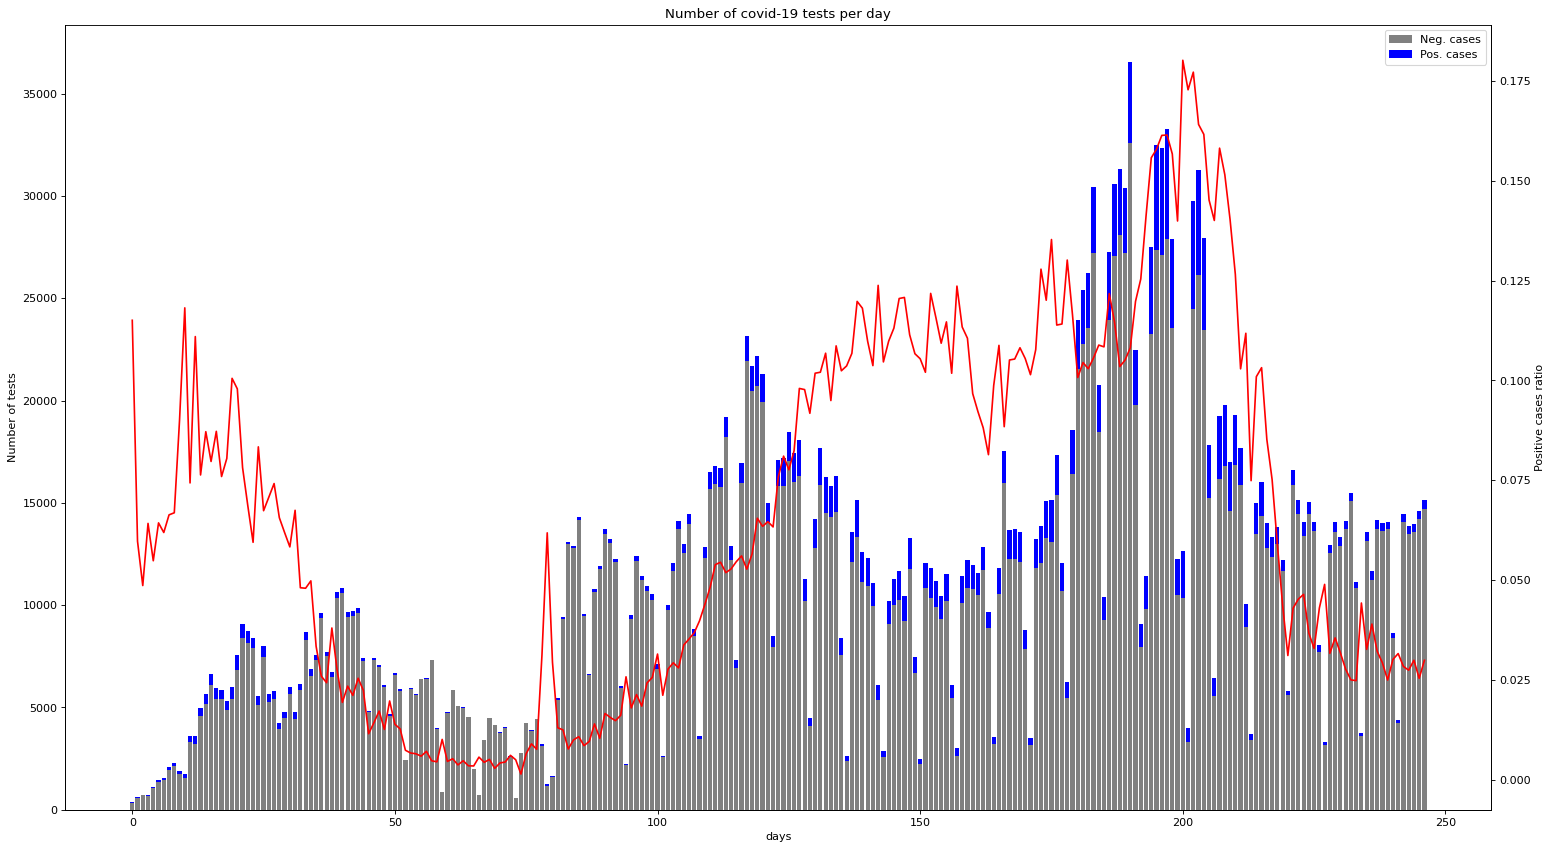

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(23, 13), dpi=80)

total_cases = df_83.groupby([df_83.test_date]).corona_result.count()
pos_cases = df_83.groupby([df_83.test_date]).corona_result.sum()
neg_cases = total_cases - pos_cases 
x = np.arange(len(pos_cases)) 

plt.bar(x, neg_cases, color = 'gray') 
plt.bar(x, pos_cases, bottom  = neg_cases, color = 'b') 
plt.xlabel("days")
plt.ylabel("Number of tests")
plt.title("Number of covid-19 tests per day")
plt.legend(['Neg. cases', 'Pos. cases'])
_ = [plt.gca().spines[i].set_visible(False) for i in ['top']]

plt.gca().twinx()
plt.gca().plot(x, pos_cases/total_cases, color = 'r')
plt.gca().set_ylabel("Positive cases ratio")
plt.show()

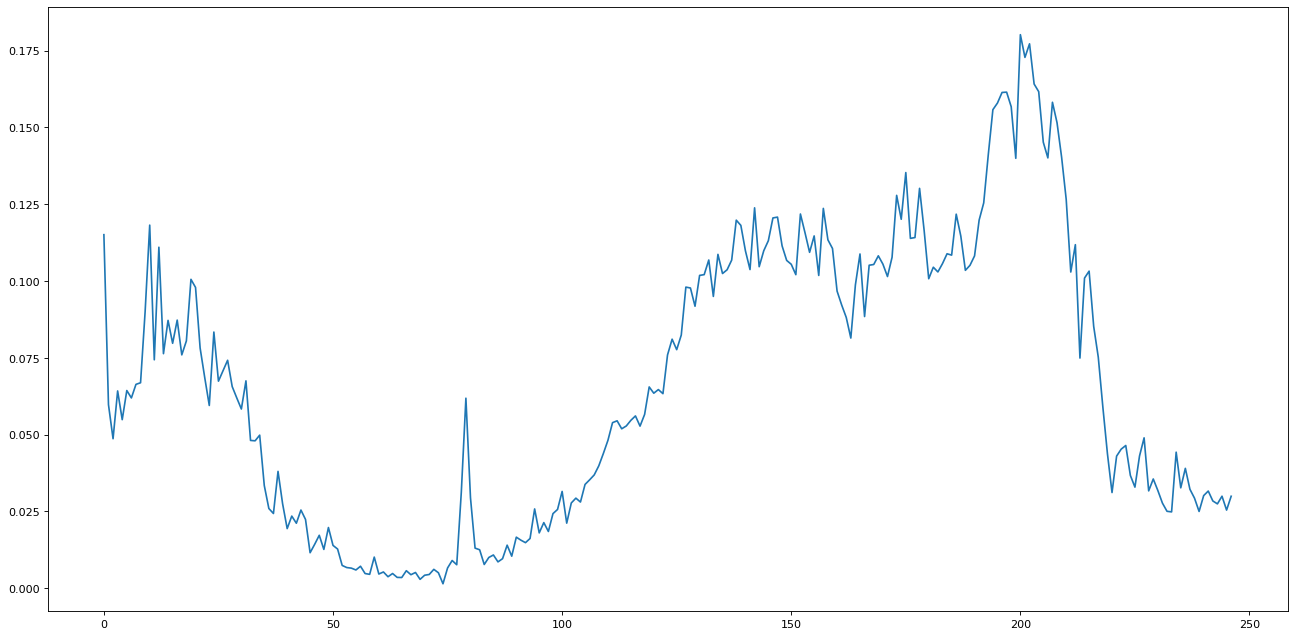

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10), dpi=80)

plt.plot(x, pos_cases/total_cases)
plt.show()


31

In [ ]:
df_6.timestamp.unique().min(), df_6.timestamp.unique().max()

(numpy.datetime64('2020-03-11T00:00:00.000000000'),
 numpy.datetime64('2020-04-30T00:00:00.000000000'))

In [ ]:
df_6.timestamp.unique().min(), df_6.timestamp.unique().max()

AttributeError: ignored

# Play 1

In [ ]:
import lightgbm as lgb

In [ ]:
df_6.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0,0,0,0,0,negative,None,female,Other
1,2020-04-30,1,0,0,0,0,negative,None,female,Other
2,2020-04-30,0,1,0,0,0,negative,None,male,Other
3,2020-04-30,1,0,0,0,0,negative,None,female,Other
4,2020-04-30,1,0,0,0,0,negative,None,male,Other


In [ ]:

df_6.assign(contact_with_confirmed = lambda x : x.test_indication == 'Contact with confirmed')

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,contact_with_confirmed
0,2020-04-30,0,0,0,0,0,negative,None,female,Other,False
1,2020-04-30,1,0,0,0,0,negative,None,female,Other,False
2,2020-04-30,0,1,0,0,0,negative,None,male,Other,False
3,2020-04-30,1,0,0,0,0,negative,None,female,Other,False
4,2020-04-30,1,0,0,0,0,negative,None,male,Other,False
...,...,...,...,...,...,...,...,...,...,...,...
278843,2020-03-11,0,0,0,0,0,negative,None,None,Other,False
278844,2020-03-11,0,0,0,0,0,negative,None,None,Other,False
278845,2020-03-11,0,0,0,0,0,positive,None,None,Contact with confirmed,True
278846,2020-03-11,0,0,0,0,0,other,None,None,Other,False


In [ ]:
x = df_6.drop(['corona_result', ''])